In [111]:
from __future__ import print_function 
import os 
from textwrap import wrap
import locale
import pandas as pd 
import numpy as np 

%matplotlib inline 
from matplotlib import pyplot as plt 

from pandas.plotting import autocorrelation_plot

from statsmodels.tsa import stattools

locale.setlocale(locale.LC_ALL, '')
register_matplotlib_converters()

In [53]:
def remove_tick_lines(which, ax):
    if which == 'y':
        for line in ax.yaxis.get_majorticklines():
            line.set_visible(False)
    elif which == 'x':
        for line in ax.xaxis.get_majorticklines():
            line.set_visible(False)
    else:
        assert False, "Wrong axis parameter."

def every_nth_tick(ax, every_nth = 2):
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

def autolabel(rects, ax, dec_no=0):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height + (height * 0.01),
                '%s' % round(height, dec_no),
                ha='center', va='bottom')

def set_axes_common_properties(axe, no_grid=False):
    rv = 1
    try:
        axe.spines['top'].set_visible(False)
        axe.spines['left'].set_visible(False)
        axe.spines['right'].set_visible(False)
        axe.spines['bottom'].set_visible(False)
        if no_grid == False:
            axe.grid(color='#636262', linestyle='-.', linewidth=0.2)
        rv = 0
    except Exception as ex:
        print("Errore - {e}".format(e=str(ex)))
        
    return rv

#
# Decoding dataframe: the values and description are from the metadata
# document.
#
quarter_decode = {"codice":[1 ,2 ,3 ,4], "Trimestre": ["Primo trimestre" ,"Secondo trimestre" ,"Terzo trimestre" ,"Quarto trimestre"]}
quarter_decode = pd.DataFrame.from_records(quarter_decode, columns=['codice','Trimestre'])
quarter_decode.set_index('codice', inplace=True)

genere_persona = { "codice": [1, 2, 0], "Genere": ["maschio", "femmina", "non dato"] }
genere_persona = pd.DataFrame.from_records(genere_persona, columns=['codice','Genere'])

big_city_GRACOM = {"codice": ["00000", "001272", "010025", "015146", "023091", "027042", "037006", "048017", "058091", "063049", "072006", "082053", "083048", "087015"],
                   "Nome Città": ["Altro" ,"TORINO" ,"GENOVA" ,"MILANO" ,"VERONA" ,"VENEZIA" ,"BOLOGNA" ,"FIRENZE" ,"ROMA" ,"NAPOLI" ,"BARI" ,"PALERMO" ,"MESSINA" ,"CATANIA"]}
big_city_GRACOM = pd.DataFrame.from_records(big_city_GRACOM, columns=['codice','Nome Città'])

si_no_sg16 = { "codice": [1, 2, 0], "Nazionalità Italiana": ["SI", "NO", "non dato"] }
si_no_sg16 = pd.DataFrame.from_records(si_no_sg16, columns=['codice','Nazionalità Italiana'])

tipo_lavoro = { "codice": [1, 2, 3, 4, 5, 6, 7, 8], "Tipo lavoro": [ "Un lavoro alle dipendenze" ,"Un lavoro di: Collaborazione coordinata e continuativa (con o senza progetto)" ,"Un lavoro di: Prestazione d'opera occasionale" ,"Un lavoro autonomo come: Imprenditore" ,"Un lavoro autonomo come: Libero professionista" ,"Un lavoro autonomo come: Lavoratore in proprio" ,"Un lavoro autonomo come: Coadiuvante nell'azienda di un familiare" ,"Un lavoro autonomo come: Socio di cooperativa" ] }
tipo_lavoro = pd.DataFrame.from_records(tipo_lavoro, columns=['codice','Tipo lavoro'])

regione = {"codice": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], "Regione": ["Piemonte" ,"Valle d'Aosta" ,"Lombardia" ,"Trentino alto Adige" ,"Veneto" ,"Friuli Venezia Giulia" ,"Liguria" ,"Emilia Romagna" ,"Toscana" ,"Umbria" ,"Marche" ,"Lazio" ,"Abruzzo" ,"Molise" ,"Campania" ,"Puglia" ,"Basilicata" ,"Calabria" ,"Sicilia" ,"Sardegna"]}
regione = pd.DataFrame.from_records(regione, columns=['codice','Regione'])

it_est_sg13 = {"codice": [1, 2], "Luogo nascita":["In Italia", "All'estero"]}
it_est_sg13 = pd.DataFrame.from_records(it_est_sg13, columns=['codice','Luogo nascita'])

diploma_SG24A = {"codice": ["001", "002", "003", "997"], "Diploma":["Diploma", "Afam I livello", "Afam II livello", "Non sa"],"Diploma long": ["Diploma (vecchio ordinamento)" ,"Diploma accademico di alta formazione artistica, musicale e coreutica di I livello" ,"Diploma accademico di alta formazione artistica, musicale e coreutica di II livello" ,"Non sa"]}
diploma_SG24A = pd.DataFrame.from_records(diploma_SG24A, columns=['codice','Diploma'])

laurea_SG24B = {"codice": ["1" ,"2" ,"3" ,"4" ,"5"], "Laurea long": [ "Master universitario di I livello/ Diploma accademico di perfezionamento o Master di I livello/Diploma accademico di specializzazione di I livello" ,"Master universitario di II livello/ Diploma accademico di perfezionamento o Master di II livello/Diploma accademico di specializzazione di II livello" ,"Diploma di specializzazione universitaria" ,"Dottorato di ricerca/Diploma accademico di formazione alla ricerca AFAM" ,"Nessuno di questi"], "Laurea": [ "Master o Laurea I livello" ,"Master o Laurea II livello" ,"Diploma di specializzazione universitaria" ,"Dottorato di ricerca/Diploma AFAM" ,"Nessuno di questi" ] }
laurea_SG24B = pd.DataFrame.from_records(laurea_SG24B, columns=['codice', 'Laurea', "Laurea long"])

age_bracket_ETAM = {
    "codice": ["00"  ,"03"   ,"06"    ,"11"    ,"15" ,"16" ,"17" ,"18" ,"19" ,"20" ,"21" ,"22" ,"23" ,"24" ,"25" ,"26" ,"27" ,"28" ,"29" ,"30" ,"31" ,"32" ,"33" ,"34" ,"35" ,"36" ,"37" ,"38" ,"39" ,"40" ,"41" ,"42" ,"43" ,"44" ,"45" ,"46" ,"47" ,"48" ,"49" ,"50" ,"51" ,"52" ,"53" ,"54" ,"55" ,"56" ,"57" ,"58" ,"59" ,"60" ,"61" ,"62" ,"63" ,"64" ,"65" ,"66" ,"67" ,"68" ,"69" ,"70" ,"71" ,"72" ,"73" ,"74" ,"75"],
    "Eta'":   ["0-2" ,"03-5" ,"06-10" ,"11-14" ,"15" ,"16" ,"17" ,"18" ,"19" ,"20" ,"21" ,"22" ,"23" ,"24" ,"25" ,"26" ,"27" ,"28" ,"29" ,"30" ,"31" ,"32" ,"33" ,"34" ,"35" ,"36" ,"37" ,"38" ,"39" ,"40" ,"41" ,"42" ,"43" ,"44" ,"45" ,"46" ,"47" ,"48" ,"49" ,"50" ,"51" ,"52" ,"53" ,"54" ,"55" ,"56" ,"57" ,"58" ,"59" ,"60" ,"61" ,"62" ,"63" ,"64" ,"65" ,"66" ,"67" ,"68" ,"69" ,"70" ,"71" ,"72" ,"73" ,"74" ,"75 e +"]
}
age_bracket_ETAM = pd.DataFrame.from_records(age_bracket_ETAM, columns=['codice', "Eta'"])

# This is somehow arbitrary, set the ages where one shouldn't work.
non_working_ages = ["0-2","03-5","06-10","11-14","15", "64","65","66","67","68" ,"69" ,"70" ,"71" ,"72" ,"73" ,"74" ,"75 e +"]
under_age = non_working_ages[0:5]
over_age = non_working_ages[5:]

education_level_EDULEV = {
"codice": ["0" ,"1" ,"2" ,"3" ,"4" ,"5" ,"6"],
"Titolo di studio": ["Non dato" ,"Nessun titolo" ,"Licenza elementare" ,"Licenza media" ,"Diploma 2-3" ,"Diploma 4-5" ,"Laurea"]
}    
education_level_EDULEV = pd.DataFrame.from_records(education_level_EDULEV, columns=['codice', "Titolo di studio"])

education_level_TITSTUD = {
    "codice": ["01" ,"02" ,"03" ,"04", "05", "06" ,"07" ,"08" ,"09" ,"10"],
    "Titolo studio long": [
         "Nessun titolo"
        ,"Licenza elementare / Attestato di valutazione finale"
        ,"Licenza media (dall'anno 2007 denominata \"Diploma di Istruzione secondaria di I grado\") o avviamento professionale (conseguito non oltre all'anno 1965)"
        ,"Diploma di qualifica professionale di scuola secondaria superiore (di II grado) di 2-3 anni che non permette l'iscrizione all'Università / Attestato IFP di qualifica professionale triennale (operatore) / Diploma professionale IFP di tecnico (quarto anno)"
        ,"Diploma di maturità / Diploma di istruzione secondaria superiore (di II grado) di 4-5 anni che permette l'iscrizione all'Università / Certificato di specializzazione tecnica superiore IFTS (dal 2000) / Diploma di tecnico superiore ITS (corsi biennali)"
        ,"Diploma di Accademia (Belle Arti, Nazionale di arte drammatica, Nazionale di Danza), Istituto superiore Industrie artistiche, Conservatorio di musica statale, Istituto di Musica Pareggiato"
        ,"Diploma universitario di due/tre anni, Scuola diretta a fini speciali, Scuola parauniversitaria"
        ,"Laurea di primo livello (triennale)"
        ,"Laurea specialistica/magistrale (biennale)"
        ,"Laurea di 4-6 anni: laurea del vecchio ordinamento o laurea specialistica/magistrale a ciclo unico"
    ],
    "Titolo studio": [
         "Nessun titolo"
        ,"Licenza elementare"
        ,"Licenza media"
        ,"Diploma di qualifica professionale 2-3 anni"
        ,"Diploma di maturità"
        ,"Diploma di Accademia"
        ,"Diploma universitario di due/tre anni"
        ,"Laurea di primo livello (triennale)"
        ,"Laurea specialistica/magistrale (biennale)"
        ,"Laurea del vecchio ordinamento"
    ]
}
education_level_TITSTUD = pd.DataFrame.from_records(education_level_TITSTUD, columns=['codice', "Titolo studio"])

working_status_COND3 = {"codice": [1, 2, 3], "Stato occupazionale": ["occupati", "persone in cerca", "inattivi"]}
working_status_COND3 = pd.DataFrame.from_records(working_status_COND3, columns=['codice', "Stato occupazionale"])

working_status_COND10 = {"codice": ["01" ,"02" ,"03" ,"04" ,"05" ,"06" ,"07" ,"08" ,"09" ,"10"],
                         "Stato occupazionale dettaglio": [ "occupati" ,"persone in cerca, con precedenti esperienze, ex-occupati" ,"persone in cerca, con precedenti esperienze, ex-inattivi" ,"persone in cerca, senza precedenti esperienze" ,"inattivi in età lav., cercano non attivamente ma disponibili" ,"inattivi in età lav., cercano ma non disponibili" ,"inattivi in età lav., non cercano ma disponibili" ,"inattivi in età lav., non cercano e non disponibili (anche militari di leva e inabili al lavoro)" ,"inattivi in età non lav., meno di 15 anni" ,"inattivi in età non lav., più di 64 anni" ]}
working_status_COND10 = pd.DataFrame.from_records(working_status_COND10, columns=['codice', "Stato occupazionale dettaglio"])

dtype_dict = {
    'codice': 'object',
    'EDULEV': 'object'
}
nations_decode_file = os.path.join("..","data","nations-decode.csv")
nd_df = pd.read_csv(nations_decode_file, sep=',', lineterminator='\n',low_memory=False, dtype=dtype_dict)


In [23]:
images_path = os.path.join("..","images")
data_file = os.path.join("..","data","MICRODATI","RCFL_Microdati_2019_Secondo_trimestre.txt")

dtype_dict = {
    'ETAM': 'object',
    'EDULEV': 'object',
    'CITSES': 'object',
    'COND10': 'object'
}
df = pd.read_csv(data_file, sep='\t', lineterminator='\n',low_memory=False, dtype=dtype_dict)

# Some common varibles.
year = df['ANNO'].value_counts().index[0]
quarter = df['TRIM'].value_counts().index[0]
quarter_name = quarter_decode.loc[1]['Trimestre']
file_prefix = "{y}-{q}-".format(y=year,q=quarter)
sample_tot_num = df.shape[0]

(df.shape, df["EDULEV"].dtypes, education_level_EDULEV['codice'].dtype) #, df.dtypes)

((99333, 343), dtype('O'), dtype('O'))

In [11]:
(under_age,over_age)

(['0-2', '03-5', '06-10', '11-14', '15'],
 ['68', '69', '70', '71', '72', '73', '74', '75 e +'])

In [35]:

# Set a default code for the rows that doesn't have one.
df['EDULEV'] = df['EDULEV'].apply(lambda row: "0" if row == ' ' else row)
df["GRACOM"] = df["GRACOM"].apply(lambda row: "00000" if row not in big_city_GRACOM['codice'].values else row)
df['CITSES'] = df['CITSES'].apply(lambda row: "000" if row not in nd_df['codice'].values else row)

# Do all the merges to have the human readable values instead of codes (for small datasets).
df_red = df[['REG', "GRACOM", 'ETAM', 'SG11', 'SG13', 'SG16', 'EDULEV','CITSES','COND3','COND10']]

# Do all the joins to decode the used variables (NOTE: ok for a small df like this one).
df_red = pd.merge(df_red, regione, left_on='REG', right_on='codice')
df_red = pd.merge(df_red, it_est_sg13, left_on='SG13', right_on='codice')
df_red = pd.merge(df_red, si_no_sg16, left_on='SG16', right_on='codice')
df_red = pd.merge(df_red, genere_persona, left_on='SG11', right_on='codice')
df_red = pd.merge(df_red, age_bracket_ETAM,left_on='ETAM', right_on='codice')
df_red = pd.merge(df_red, education_level_EDULEV, how='outer', left_on='EDULEV', right_on='codice')
df_red = pd.merge(df_red, big_city_GRACOM,left_on='GRACOM', right_on='codice')
df_red = pd.merge(df_red, nd_df,left_on='CITSES', right_on='codice')
df_red = pd.merge(df_red, working_status_COND3, left_on='COND3', right_on='codice')

df_red = pd.merge(df_red, working_status_COND10, left_on='COND10', right_on='codice')


#df_red.rename(index=str, columns={"ETAM": "Eta'"}, inplace=True)

df_red.drop(columns=['REG','SG13', 'SG16', 'SG11', 'ETAM','EDULEV','GRACOM','CITSES','COND3','COND10',
                    "codice_x", "codice_y"], inplace=True)
df_red.head(2)

,Regione,Luogo nascita,Nazionalità Italiana,Genere,Eta',Titolo di studio,Nome Città,Nome Nazione,Stato occupazionale,Stato occupazionale dettaglio
0,Molise,In Italia,SI,maschio,75 e +,Nessun titolo,Altro,Italia,inattivi,"inattivi in età non lav., più di 64 anni"
1,Molise,In Italia,SI,maschio,75 e +,Nessun titolo,Altro,Italia,inattivi,"inattivi in età non lav., più di 64 anni"


In [13]:
# Data integrity check...
reduced_df_tot_num = df_red.shape[0]
assert reduced_df_tot_num == sample_tot_num, "After the join operations the number of rows must be the same (red: {n1}, tot: {n2}).".format(n1=reduced_df_tot_num,n2=sample_tot_num)
(reduced_df_tot_num, sample_tot_num)

(99333, 99333)

In [30]:
df_red.head(2)

,Regione,Luogo nascita,Nazionalità Italiana,Genere,Eta',Titolo di studio,Nome Città,Nome Nazione,Stato occupazionale,Stato occupazionale dettaglio
0,Molise,In Italia,SI,maschio,75 e +,Nessun titolo,Altro,Italia,inattivi,"inattivi in età non lav., più di 64 anni"
1,Molise,In Italia,SI,maschio,75 e +,Nessun titolo,Altro,Italia,inattivi,"inattivi in età non lav., più di 64 anni"


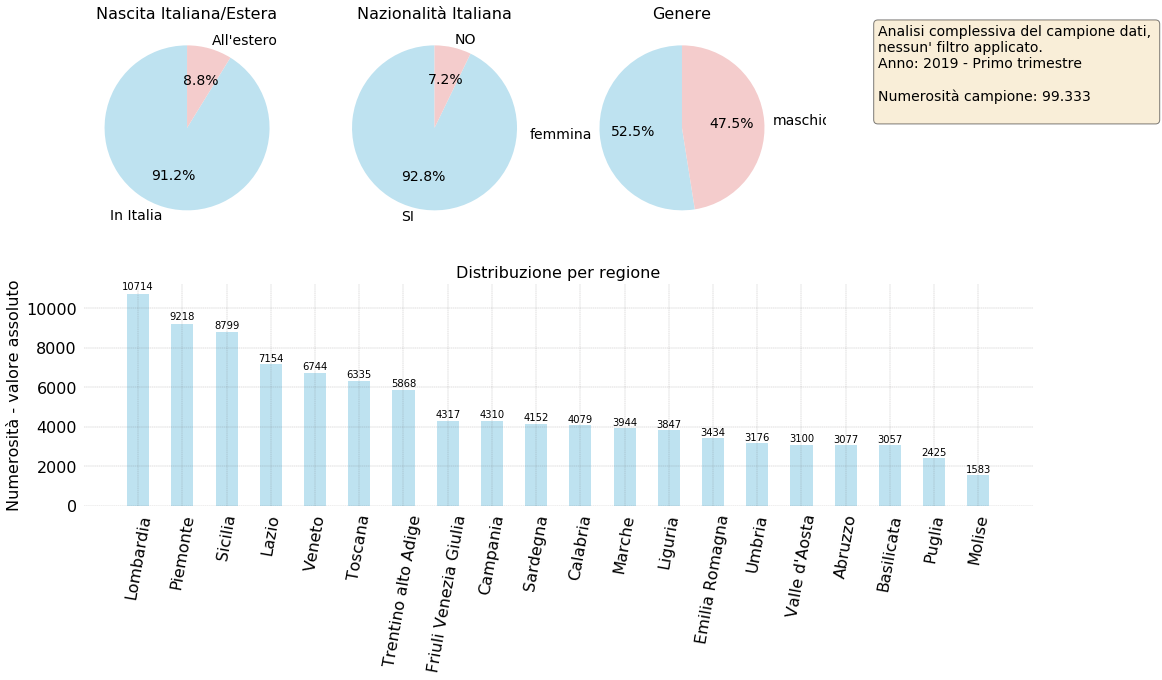

In [15]:

fig = plt.figure(figsize=(17, 9))
gs = fig.add_gridspec(2, 4)

ax = []
ax.append(fig.add_subplot(gs[0, 0]))
ax.append(fig.add_subplot(gs[0, 1]))
ax.append(fig.add_subplot(gs[0, 2]))
ax.append(fig.add_subplot(gs[0, 3]))
ax.append(fig.add_subplot(gs[1, :]))

# ------------------------------------------------------------------------
set_axes_common_properties(ax[0])

# Count of the place of birth: Italy / Other.
it_est_cnt = df_red['Luogo nascita'].value_counts()

# Count nationality of the work force.
nationality = df_red['Nazionalità Italiana'].value_counts()

# Count nationality of the work force.
gender = df_red['Genere'].value_counts()

colors = ["#BEE2F0", "#F4CCCC", "#81898c"]

# ------------------------------------------------------------------------
# Pie chart.
idx = 0
ax[idx].set_title("Nascita Italiana/Estera", fontsize=16)
ch1 = ax[idx].pie(it_est_cnt.values,
          labels=it_est_cnt.index,
          shadow=False,
          colors=colors,
          startangle=90,
          autopct='%1.1f%%',
          textprops={'fontsize': 14})

# ------------------------------------------------------------------------
idx = 1
ax[idx].set_title("Nazionalità Italiana", fontsize=16)
ch2 = ax[idx].pie(nationality.values,
          labels=nationality.index,
          shadow=False,
          colors=colors,
          startangle=90,
          autopct='%1.1f%%',
          textprops={'fontsize': 14})

# ------------------------------------------------------------------------
idx = 2
ax[idx].set_title("Genere", fontsize=16)
ch2 = ax[idx].pie(gender.values,
          labels=gender.index,
          shadow=False,
          colors=colors,
          startangle=90,
          autopct='%1.1f%%',
          textprops={'fontsize': 14})

# ------------------------------------------------------------------------
idx = 3
sample_num = f'{df.shape[0]:n}'.format()
text = """Analisi complessiva del campione dati, 
nessun' filtro applicato.
Anno: {y} - {q}

Numerosità campione: {n}
""".format(y=year,q=quarter_name,n=sample_num)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[idx].text(0.25, 0.55, text, fontsize=14, bbox=props)
set_axes_common_properties(ax[idx], True)
ax[idx].get_xaxis().set_ticks([])
ax[idx].get_yaxis().set_ticks([])

# ------------------------------------------------------------------------
idx = 4
width = 0.5

regions_dist = df_red['Regione'].value_counts().to_frame()
region_num = regions_dist['Regione']
region_labels = regions_dist.index

rects_region = ax[idx].bar(region_labels, region_num, width=width, color=colors[0])
set_axes_common_properties(ax[idx])

autolabel(rects_region, ax[idx])

ax[idx].set_xticklabels(region_labels, rotation=80)
ax[idx].tick_params(axis='both', labelsize=16)
ax[idx].set_title("Distribuzione per regione", fontsize=16)
ax[idx].set_ylabel("Numerosità - valore assoluto", fontsize=16)

remove_tick_lines('y', ax[idx])
remove_tick_lines('x', ax[idx])

plt.savefig(os.path.join(images_path,"{prefix}forza_lavoro_composizione.png".format(prefix=file_prefix)))



In [37]:
esteri_mask = df_red['Nazionalità Italiana'] != 'SI'
italian_mask = df_red['Nazionalità Italiana'] == 'SI'

# Data integrity check...
it_fr_total_num = df_red[esteri_mask].shape[0] + df_red[italian_mask].shape[0]
assert it_fr_total_num == sample_tot_num, "The sum of the two sets must be equal to the total number of rows."

df_red[esteri_mask].head(3)

,Regione,Luogo nascita,Nazionalità Italiana,Genere,Eta',Titolo di studio,Nome Città,Nome Nazione,Stato occupazionale,Stato occupazionale dettaglio
29368,Sicilia,All'estero,NO,maschio,75 e +,Nessun titolo,Altro,Albania,inattivi,"inattivi in età non lav., più di 64 anni"
29369,Abruzzo,All'estero,NO,femmina,75 e +,Nessun titolo,Altro,Albania,inattivi,"inattivi in età non lav., più di 64 anni"
29370,Trentino alto Adige,All'estero,NO,femmina,75 e +,Nessun titolo,Altro,Albania,inattivi,"inattivi in età non lav., più di 64 anni"


In [133]:
# Occupational status analysis - see how many wokrs and i there is differeces
# among italan and foregneirs.

for_ocup_status = df_red[esteri_mask]['Stato occupazionale'].value_counts().to_frame()
ita_ocup_status = df_red[italian_mask]['Stato occupazionale'].value_counts().to_frame()

# Data integrity check...
ita_sum = ita_ocup_status['Stato occupazionale'].sum()
for_sum = for_ocup_status['Stato occupazionale'].sum()
assert ita_sum + for_sum == df_red.shape[0], "The sum of the two sets must be equal to the whole set ({s1},{s2}, {whole}).".format(s1=ita_sum,s2=for_sum,whole=df_red.shape[0])

for_ocup_status = df_red[esteri_mask & ~df_red["Eta'"].isin(non_working_ages)]['Stato occupazionale'].value_counts().to_frame()
ita_ocup_status = df_red[italian_mask & ~df_red["Eta'"].isin(non_working_ages)]['Stato occupazionale'].value_counts().to_frame()

# Study of the residuals outside the working ages.
m1 = df_red["Eta'"].isin(over_age)
m2 = df_red["Stato occupazionale"].isin(["occupati", "persone in cerca"])

# Foregneirs over 68 (see the decpoding cell).
fr_overage_count = df_red[m1 & m2 & esteri_mask].groupby(['Stato occupazionale', "Eta'"]).size()
fr_overage_count = fr_overage_count.reset_index(name='Numero')

it_overage_count = df_red[m1 & m2 & italian_mask].groupby(['Stato occupazionale', "Eta'"]).size()
it_overage_count = it_overage_count.reset_index(name='Numero')

# Detailed job status analysis.
m4 = ~ df_red["Eta'"].isin(non_working_ages)
it_occ_stat_dettail = df_red[italian_mask & m4]["Stato occupazionale dettaglio"].value_counts().to_frame()
fr_occ_stat_dettail = df_red[esteri_mask & m4]["Stato occupazionale dettaglio"].value_counts().to_frame()

tot_oc_s = fr_occ_stat_dettail["Stato occupazionale dettaglio"].sum()
fr_occ_stat_dettail["% Stato occupazionale dettaglio"] = fr_occ_stat_dettail.apply(lambda row: round((row / tot_oc_s) * 100, 2))

tot_oc_s = it_occ_stat_dettail["Stato occupazionale dettaglio"].sum()
it_occ_stat_dettail["% Stato occupazionale dettaglio"] = it_occ_stat_dettail.apply(lambda row: round((row / tot_oc_s) * 100, 2))


unempl_fr = fr_occ_stat_dettail["Stato occupazionale dettaglio"]

(fr_overage_count['Numero'].sum(), it_overage_count['Numero'].sum())


(111, 1603)

In [135]:
# Data integrity check...
m3_inactive = df_red["Stato occupazionale"].isin(["inattivi"])

overage_inactive = df_red[m1 & m3_inactive]

ita_sum = ita_ocup_status['Stato occupazionale'].sum()
for_sum = for_ocup_status['Stato occupazionale'].sum()

residuals = fr_overage_count['Numero'].sum() + it_overage_count['Numero'].sum()
underage = df_red[df_red["Eta'"].isin(under_age)].shape[0]

# Assertions ...
assert ita_sum+for_sum+residuals+underage+overage_inactive.shape[0] == df_red.shape[0], "Occup. status (reduced) - The sum of the parts must be equal to the total."
assert (it_occ_stat_dettail.sum()+fr_occ_stat_dettail.sum()+residuals+underage+overage_inactive.shape[0])[0] == df_red.shape[0], "Detailed occup status - the sum must be equal the total."

perc_sum = fr_occ_stat_dettail["% Stato occupazionale dettaglio"].sum() 
assert perc_sum >= 9.99 and perc_sum <= 100, "Check the percentage."

("ita_sum: {its}, for_sum: {fs}, residuals: {re}, underage: {ua}, overage inactive: {oi} | sum: {sum} | all {all}".format(
                                                                                its=ita_sum
                                                                               ,fs=for_sum
                                                                               ,re=residuals
                                                                               ,ua=underage
                                                                               ,oi=overage_inactive.shape[0]
                                                                               ,sum=(ita_sum+for_sum+residuals+underage+overage_inactive.shape[0])
                                                                               ,all=df_red.shape[0]))

'ita_sum: 49032, for_sum: 5385, residuals: 1714, underage: 12582, overage inactive: 30620 | sum: 99333 | all 99333'

In [136]:
# Drop the employed rows.
fr_occ_stat_dettail.drop('occupati', inplace=True)
it_occ_stat_dettail.drop('occupati', inplace=True)

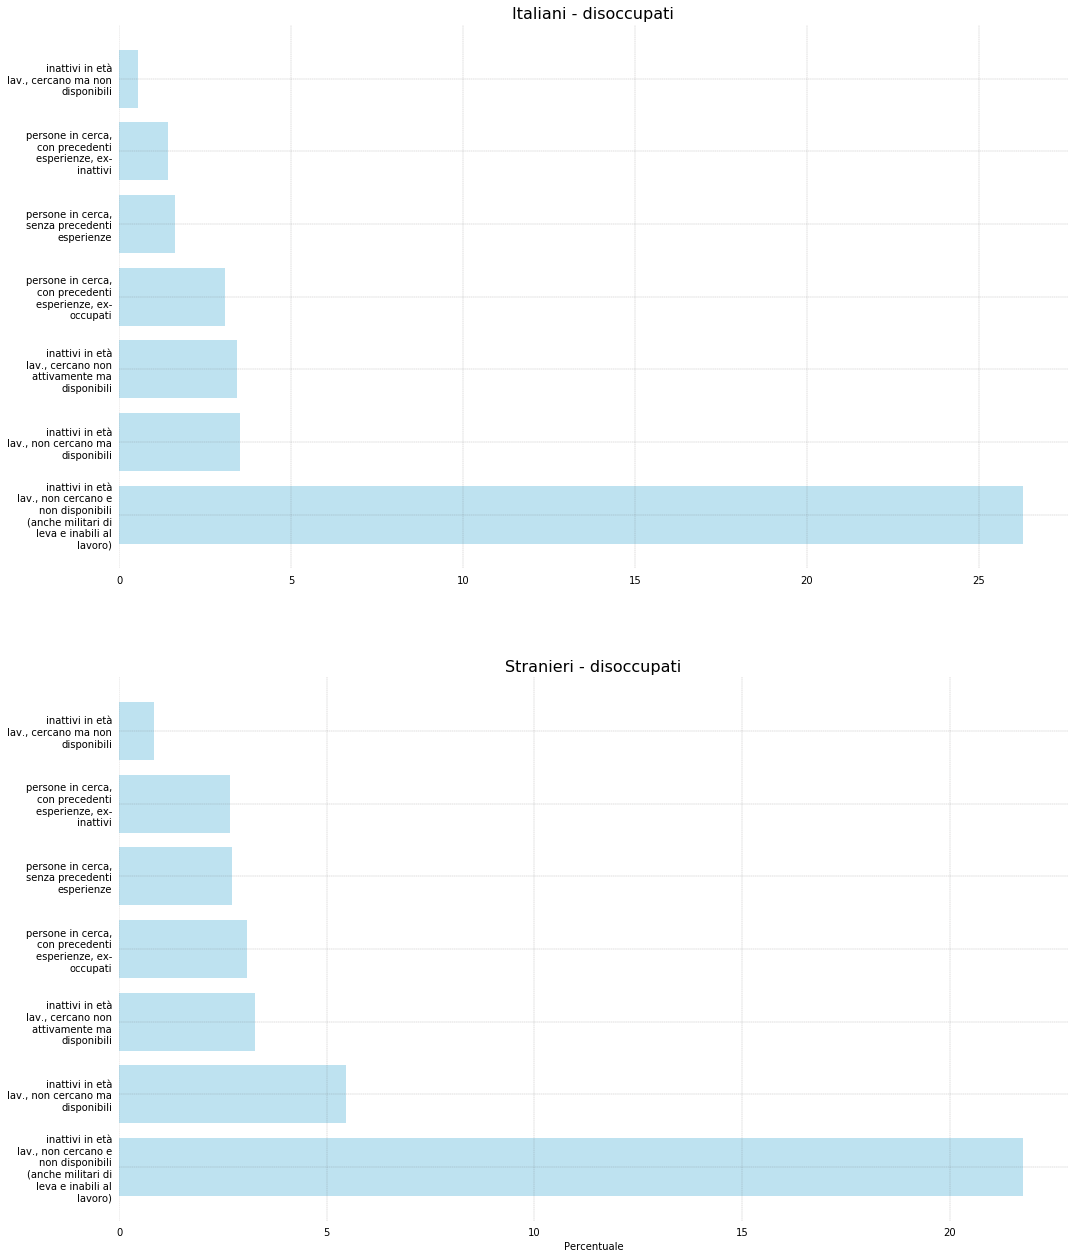

In [141]:
#
# Unemploid status using the detailed description.
#
colors = {
    "default": "#BEE2F0",
    "male": "#BEE2F0",
    "male dark": "#6faff7",
    "female": "#0678f7"
}

fig = plt.figure(figsize=(17, 34))
gs = fig.add_gridspec(3, 3)

ax = []
ax.append(fig.add_subplot(gs[1,0:]))
ax.append(fig.add_subplot(gs[2,0:]))

# ------------------------------------------------------------------------
idx = 0

width = 0.5

it_os_dett_lbl = it_occ_stat_dettail.index.values
it_os_dett_lbl = [ '\n'.join(wrap(l, 20)) for l in it_os_dett_lbl ]

it_os_dett_val = it_occ_stat_dettail["% Stato occupazionale dettaglio"].values


rects_it_oa = ax[idx].barh(it_os_dett_lbl, it_os_dett_val, color=colors['default'])
set_axes_common_properties(ax[idx])

ax[idx].set_title("Italiani - disoccupati", fontsize=16)


remove_tick_lines('y', ax[idx])
remove_tick_lines('x', ax[idx])

# ------------------------------------------------------------------------
idx = 1

width = 0.5

fr_os_dett_lbl = fr_occ_stat_dettail.index.values
fr_os_dett_val = fr_occ_stat_dettail["% Stato occupazionale dettaglio"].values

rects_fr_oa = ax[idx].barh(y = it_os_dett_lbl, width = fr_os_dett_val, height = 0.8
                           ,align='center'
                           , color=colors['default'])

set_axes_common_properties(ax[idx])
ax[idx].set_xlabel("Percentuale")
ax[idx].set_title("Stranieri - disoccupati", fontsize=16)

remove_tick_lines('y', ax[idx])
remove_tick_lines('x', ax[idx])

plt.savefig(os.path.join(images_path,"{prefix}analisi_stato_occupazionale_dettaglio.png".format(prefix=file_prefix)))


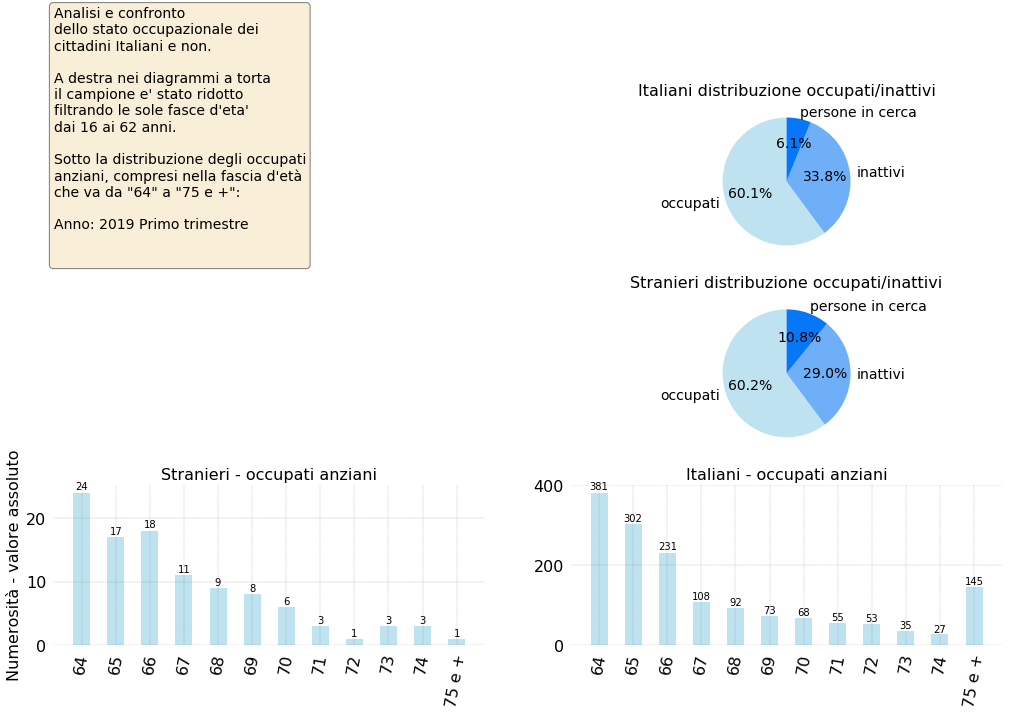

In [61]:
colors = {
    "default": "#BEE2F0",
    "male": "#BEE2F0",
    "male dark": "#6faff7",
    "female": "#0678f7"
}

fig = plt.figure(figsize=(17, 10))
gs = fig.add_gridspec(3, 2)

ax = []
ax.append(fig.add_subplot(gs[0:1, 0]))
ax.append(fig.add_subplot(gs[0,1]))
ax.append(fig.add_subplot(gs[1,1]))
ax.append(fig.add_subplot(gs[2,0]))
ax.append(fig.add_subplot(gs[2,1]))

# ------------------------------------------------------------------------
idx = 0
sample_num = f'{df.shape[0]:n}'.format()
text = """Analisi e confronto 
dello stato occupazionale dei
cittadini Italiani e non.

A destra nei diagrammi a torta
il campione e' stato ridotto
filtrando le sole fasce d'eta'
dai 16 ai 62 anni.

Sotto la distribuzione degli occupati
anziani, compresi nella fascia d'età
che va da \"{oab}\" a \"{oae}\": 

Anno: {y} {q}

""".format(y=year
           ,q=quarter_name
           ,oab=over_age[0]
           ,oae=over_age[-1])

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[idx].text(0, 0, text, fontsize=14, bbox=props)
set_axes_common_properties(ax[idx], True)
ax[idx].get_xaxis().set_ticks([])
ax[idx].get_yaxis().set_ticks([])

# -------------------------------------------------
# .
idx = 1
set_axes_common_properties(ax[idx])
ax[idx].set_title("Valutazione livello scolastico", fontsize=16)

labels = ita_ocup_status.index.values
values = ita_ocup_status['Stato occupazionale'].values

ax[idx].set_title("Italiani distribuzione occupati/inattivi", fontsize=16)
ch1 = ax[idx].pie(values,
                labels=labels,
                shadow=False,
                colors=[colors['default'],colors['male dark'],colors['female']],
                startangle=90,
                autopct='%1.1f%%',
                textprops={'fontsize': 14})

# -------------------------------------------------
# .
idx = 2
set_axes_common_properties(ax[idx])
ax[idx].set_title("Valutazione livello scolastico", fontsize=16)

labels = for_ocup_status.index.values
values = for_ocup_status['Stato occupazionale'].values

ax[idx].set_title("Stranieri distribuzione occupati/inattivi", fontsize=16)
ch1 = ax[idx].pie(values,
                labels=labels,
                shadow=False,
                colors=[colors['default'],colors['male dark'],colors['female']],
                startangle=90,
                autopct='%1.1f%%',
                textprops={'fontsize': 14})

# ------------------------------------------------------------------------
idx = 3

width = 0.5

fr_oa_occ = fr_overage_count[fr_overage_count["Stato occupazionale"] == "occupati"]
fr_oc_stat_lbl = fr_oa_occ["Eta'"]
fr_oc_stat_val = fr_oa_occ["Numero"]

rects_fr_oa = ax[idx].bar(fr_oc_stat_lbl, fr_oc_stat_val, width=width, color=colors['default'])
set_axes_common_properties(ax[idx])

autolabel(rects_fr_oa, ax[idx])

ax[idx].set_xticklabels(fr_oc_stat_lbl, rotation=80)
ax[idx].tick_params(axis='both', labelsize=16)
ax[idx].set_title("Stranieri - occupati anziani", fontsize=16)
ax[idx].set_ylabel("Numerosità - valore assoluto", fontsize=16)

remove_tick_lines('y', ax[idx])
remove_tick_lines('x', ax[idx])

# ------------------------------------------------------------------------
idx = 4

width = 0.5

it_oa_occ = it_overage_count[it_overage_count["Stato occupazionale"] == "occupati"]
it_oc_stat_lbl = it_oa_occ["Eta'"]
it_oc_stat_val = it_oa_occ["Numero"]

rects_it_oa = ax[idx].bar(it_oc_stat_lbl, it_oc_stat_val, width=width, color=colors['default'])
set_axes_common_properties(ax[idx])

autolabel(rects_it_oa, ax[idx])

ax[idx].set_xticklabels(fr_oc_stat_lbl, rotation=80)
ax[idx].tick_params(axis='both', labelsize=16)
ax[idx].set_title("Italiani - occupati anziani", fontsize=16)
#ax[idx].set_ylabel("Numerosità - valore assoluto", fontsize=16)

remove_tick_lines('y', ax[idx])
remove_tick_lines('x', ax[idx])


plt.savefig(os.path.join(images_path,"{prefix}analisi_stato_occupazionale.png".format(prefix=file_prefix)))



In [30]:
nations_count = df_red[esteri_mask]["Nome Nazione"].value_counts().to_frame()

# Data integrity check...
nc_sum = nations_count["Nome Nazione"].sum()
assert nc_sum == df_red[esteri_mask].shape[0], "The aggregation by nation must have the same number of all the foreigners filter."

nations_count['% Nazione'] = nations_count['Nome Nazione'].apply(lambda row: round((row / nc_sum) * 100, 2))

percentage_sum = nations_count['% Nazione'].sum()
assert percentage_sum >= 99.9 and percentage_sum <= 100, "The percentage sum must be very near 100%."

# Filter for the the bigger values.
cut_level = 2
mask = nations_count["% Nazione"] > cut_level

nations_count[mask].head(3)


,Nome Nazione,% Nazione
Romania,1680,23.52
Albania,730,10.22
Marocco,679,9.50


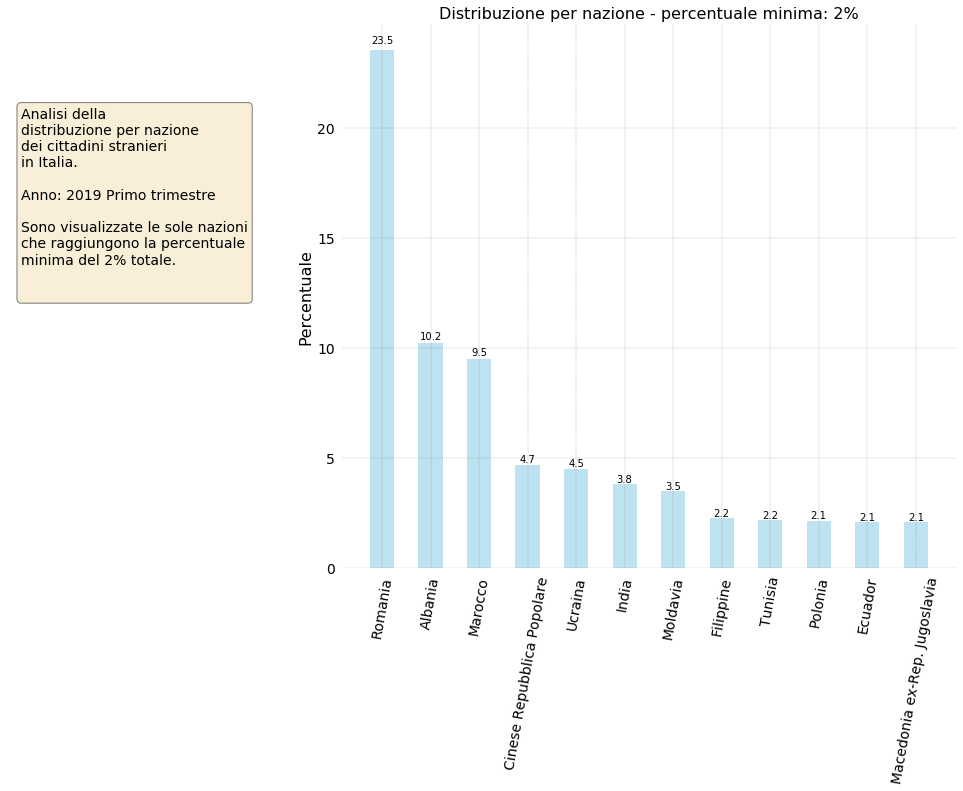

In [31]:
colors = {
    "default": "#BEE2F0",
    "male": "#BEE2F0",
    "male dark": "#0a63c8",
    "female": "#F4CCCC"
}

fig = plt.figure(figsize=(17, 10))
gs = fig.add_gridspec(1, 3)

ax = []
ax.append(fig.add_subplot(gs[0, 0:1]))
ax.append(fig.add_subplot(gs[0,1:]))

# ------------------------------------------------------------------------
idx = 0
sample_num = f'{df.shape[0]:n}'.format()
text = """Analisi della 
distribuzione per nazione
dei cittadini stranieri
in Italia. 

Anno: {y} {q}

Sono visualizzate le sole nazioni
che raggiungono la percentuale
minima del {min_perc}% totale.
 
""".format(y=year,
           q=quarter_name,
           min_perc=cut_level)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[idx].text(0.05, 0.5, text, fontsize=14, bbox=props)
set_axes_common_properties(ax[idx], True)
ax[idx].get_xaxis().set_ticks([])
ax[idx].get_yaxis().set_ticks([])

# ------------------------------------------------- 
# Nations distribution.
idx = 1
set_axes_common_properties(ax[idx])
ax[idx].set_title("Distribuzione per nazione - percentuale minima: {perc}%".format(perc=cut_level), fontsize=16)

width = 0.5
rects = ax[idx].bar(nations_count[mask].index, nations_count[mask]['% Nazione'].values, width=width, color=colors['default'], label='Percentuale')

autolabel(rects, ax[idx], 1)

ax[idx].set_ylabel("Percentuale", fontsize=16)

ax[idx].tick_params(axis='both', labelsize=14)
ax[idx].set_xticklabels(nations_count.index, rotation=80)

remove_tick_lines('y', ax[idx])
remove_tick_lines('x', ax[idx])

plt.savefig(os.path.join(images_path,"{prefix}distribuzione_per_nazione.png".format(prefix=file_prefix)))


In [12]:
mask = df_red['Nome Città'] != 'Altro'
big_cities_count = df_red[esteri_mask & mask]['Nome Città'].value_counts().to_frame()
big_cities_num = big_cities_count['Nome Città'].sum()
#print(big_cities_num)

big_cities_count['% Città'] = big_cities_count['Nome Città'].apply(lambda row: round((row / big_cities_num) * 100, 2))

bc_percentage_sum = big_cities_count['% Città'].sum()
#print(bc_percentage_sum)
assert bc_percentage_sum > 99.9 and bc_percentage_sum <= 101, "The sum of the percentuages must be near 100%."


mask = df_red['Nome Città'] == 'Altro'
other_cities_num = df_red[esteri_mask & mask]['Nome Città'].value_counts().sum()

total_foregners_num = df_red[esteri_mask].shape[0]

# Data integrity check...
assert total_foregners_num == (big_cities_num + other_cities_num), "The sum of the parts must be equalt to the total."

big_cities_count.head(3)

,Nome Città,% Città
MILANO,151,17.58
ROMA,124,14.44
TORINO,86,10.01


In [13]:
big_cities_count
big_cities_count.values

array([[151.  ,  17.58],
       [124.  ,  14.44],
       [ 86.  ,  10.01],
       [ 85.  ,   9.9 ],
       [ 76.  ,   8.85],
       [ 63.  ,   7.33],
       [ 63.  ,   7.33],
       [ 57.  ,   6.64],
       [ 45.  ,   5.24],
       [ 34.  ,   3.96],
       [ 29.  ,   3.38],
       [ 24.  ,   2.79],
       [ 22.  ,   2.56]])

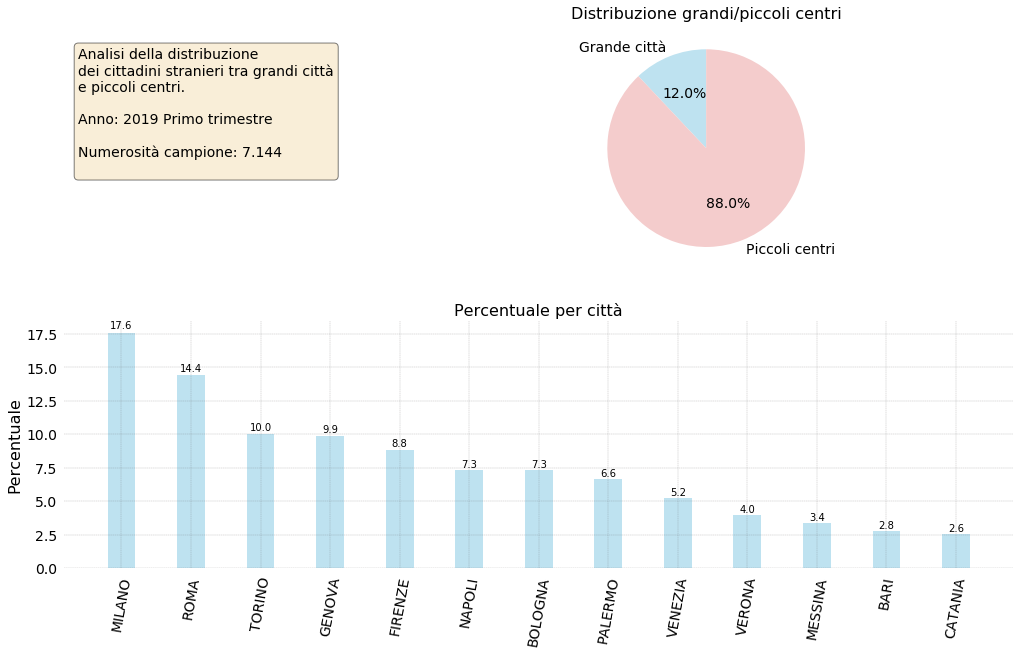

In [51]:
# Chart that compares the education level of Italian citizen 
# and foreigners citizens.

colors = {
    "default": "#BEE2F0",
    "male": "#BEE2F0",
    "male dark": "#0a63c8",
    "female": "#F4CCCC"
}

fig = plt.figure(figsize=(17, 10))
gs = fig.add_gridspec(2, 3)

ax = []
ax.append(fig.add_subplot(gs[0, 0:1]))
ax.append(fig.add_subplot(gs[0,1:]))
ax.append(fig.add_subplot(gs[1, :]))

# ------------------------------------------------------------------------
idx = 0
sample_num = f'{df.shape[0]:n}'.format()
text = """Analisi della distribuzione 
dei cittadini stranieri tra grandi città
e piccoli centri.

Anno: {y} {q}

Numerosità campione: {nfr}
""".format(y=year,
           q=quarter_name,
           nfr=f'{total_foregners_num:n}'.format())

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[idx].text(0.05, 0.4, text, fontsize=14, bbox=props)
set_axes_common_properties(ax[idx], True)
ax[idx].get_xaxis().set_ticks([])
ax[idx].get_yaxis().set_ticks([])

# -------------------------------------------------
# Big cities / small cities distribution.
idx = 1
set_axes_common_properties(ax[idx])
ax[idx].set_title("Valutazione livello scolastico", fontsize=16)

labels = ["Grande città", "Piccoli centri"]
values = [big_cities_num, other_cities_num]

ax[idx].set_title("Distribuzione grandi/piccoli centri", fontsize=16)
ch1 = ax[idx].pie(values,
                labels=labels,
                shadow=False,
                colors=[colors['default'], colors['female']],
                startangle=90,
                autopct='%1.1f%%',
                textprops={'fontsize': 14})

# ------------------------------------------------- 
# Big city distribution.
idx = 2
set_axes_common_properties(ax[idx])
ax[idx].set_title("Percentuale per città", fontsize=16)

width = 0.4
bar_index = np.asarray([i for i in range(len(big_cities_count.index))])
bar_values = big_cities_count['% Città']

rects = ax[idx].bar(big_cities_count.index, bar_values, width=width, color=colors['default'], label='Percentuale')

autolabel(rects, ax[idx], 1)

ax[idx].set_ylabel("Percentuale", fontsize=16)

ax[idx].tick_params(axis='both', labelsize=14)
ax[idx].set_xticklabels(big_cities_count.index, rotation=80)

remove_tick_lines('y', ax[idx])
remove_tick_lines('x', ax[idx])

plt.savefig(os.path.join(images_path,"{prefix}distribuzione_grandi_citta.png".format(prefix=file_prefix)))


In [15]:
it_edu_level = df_red[italian_mask]['Titolo di studio'].value_counts().to_frame()
it_total_edu_level = it_edu_level.sum()

fr_edu_level = df_red[esteri_mask]['Titolo di studio'].value_counts().to_frame()
fr_total_edu_level = fr_edu_level.sum()

it_edu_level['% Titolo di studio'] = it_edu_level['Titolo di studio'].apply(lambda row: round((row / it_total_edu_level) * 100, 2))      
fr_edu_level['% Titolo di studio'] = fr_edu_level['Titolo di studio'].apply(lambda row: round((row / fr_total_edu_level) * 100, 2))      

# Data integrity check...
it_fr_edu_lvl_total_num = fr_total_edu_level.values + it_total_edu_level.values
assert it_fr_edu_lvl_total_num[0] == sample_tot_num, "The groups of the edu levels must be equal the total number of rows."

# Data integrity check...
it_percent_sum = it_edu_level['% Titolo di studio'].sum()
fr_percent_sum = fr_edu_level['% Titolo di studio'].sum()
assert it_percent_sum > 99.9 and it_percent_sum <= 100, "The sum of the percentuages must be near 100%."
assert fr_percent_sum > 99.9 and it_percent_sum <= 100, "The sum of the percentuages must be near 100%."

#it_edu_level
(fr_total_edu_level.values[0], it_total_edu_level.values[0], it_percent_sum, fr_percent_sum)

(7144, 92189, 99.99000000000001, 99.99000000000001)

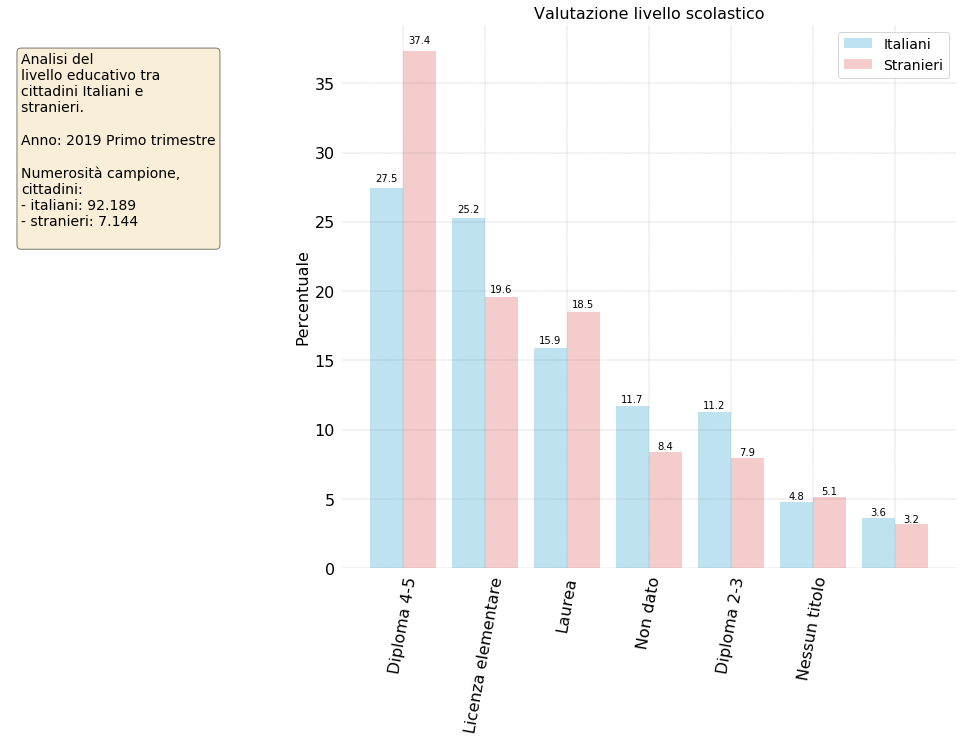

In [52]:
# Chart that compares the education level of Italian citizen 
# and foreigners citizens.

colors = {
    "default": "#BEE2F0",
    "male": "#BEE2F0",
    "male dark": "#0a63c8",
    "female": "#F4CCCC"
}

fig = plt.figure(figsize=(17, 10))
gs = fig.add_gridspec(1, 3)

ax = []
ax.append(fig.add_subplot(gs[0, 0:1]))
ax.append(fig.add_subplot(gs[0,1:]))
#ax.append(fig.add_subplot(gs[1, :]))

# ------------------------------------------------------------------------
idx = 0
sample_num = f'{df.shape[0]:n}'.format()
text = """Analisi del 
livello educativo tra
cittadini Italiani e
stranieri. 

Anno: {y} {q}

Numerosità campione,
cittadini:
- italiani: {nit}
- stranieri: {nfr}
""".format(y=year,
           q=quarter_name,
           nit=f'{it_total_edu_level.values[0]:n}'.format(),
           nfr=f'{fr_total_edu_level.values[0]:n}'.format())

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[idx].text(0.05, 0.6, text, fontsize=14, bbox=props)
set_axes_common_properties(ax[idx], True)
ax[idx].get_xaxis().set_ticks([])
ax[idx].get_yaxis().set_ticks([])

# ------------------------------------------------- 
# figures side by side.
idx = 1
set_axes_common_properties(ax[idx])
ax[idx].set_title("Valutazione livello scolastico", fontsize=16)

width = 0.4
it_idx = np.asarray([i for i in range(len(it_edu_level.index))])
it_num = it_edu_level['% Titolo di studio']

fr_num = fr_edu_level['% Titolo di studio']
fr_idx = np.asarray([i for i in range(len(fr_edu_level.index))])

rects_it = ax[idx].bar(it_idx - 0.2, it_num  , width=width, color=colors['male'], label='Italiani')
rects_fr = ax[idx].bar(fr_idx + 0.2, fr_num  , width=width, color=colors['female'], label='Stranieri')

autolabel(rects_it, ax[idx], 1)
autolabel(rects_fr, ax[idx], 1)

ax[idx].legend(fontsize=14)
ax[idx].set_ylabel("Percentuale", fontsize=16)

ax[idx].tick_params(axis='both', labelsize=16)
ax[idx].set_xticklabels(it_edu_level.index, rotation=80)

remove_tick_lines('y', ax[idx])
remove_tick_lines('x', ax[idx])

plt.savefig(os.path.join(images_path,"{prefix}valutazione_livello_educativo.png".format(prefix=file_prefix)))


In [17]:
# Filter out all the Italian elements in the sample.
esteri_mask = df_red['Nazionalità Italiana'] != 'SI'

foreigner_male = esteri_mask & (df_red['Genere'] == 'maschio')
foreigner_female = esteri_mask & (df_red['Genere'] == 'femmina')

foreigner_male_by_age = df_red[foreigner_male]["Eta'"].value_counts()
foreigner_male_by_age.sort_index(ascending=True, inplace=True)

foreigner_female_by_age = df_red[foreigner_female]["Eta'"].value_counts()
foreigner_female_by_age.sort_index(ascending=True, inplace=True)

# Data integrity check...
fr_total_num = df_red[esteri_mask].shape[0]
fr_female_subset_num = foreigner_female_by_age.sum()
fr_male_subset_num = foreigner_male_by_age.sum()
assert fr_total_num == (fr_male_subset_num + fr_female_subset_num), "The sum of the age partitition sets must be equal to the total."

(fr_total_num, fr_female_subset_num, fr_male_subset_num)

(7144, 3905, 3239)

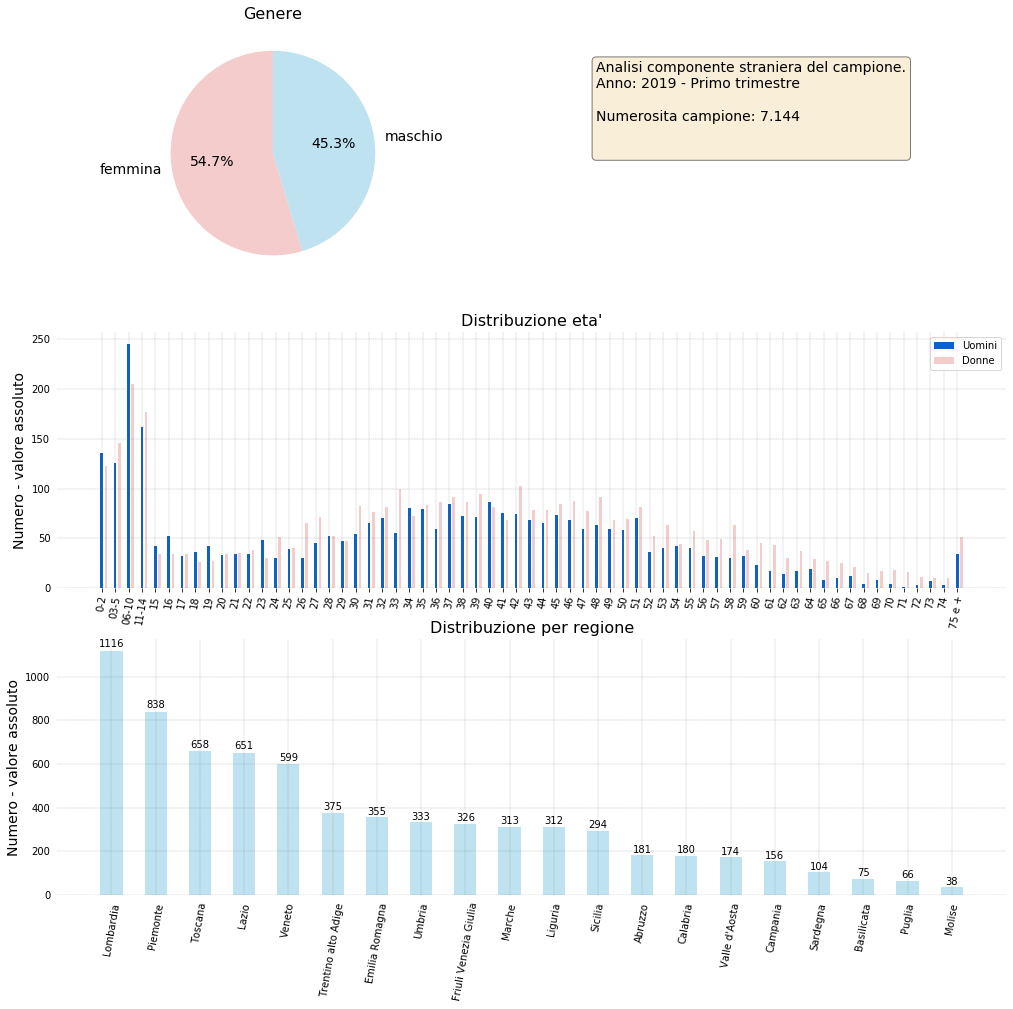

In [58]:

fig = plt.figure(figsize=(17, 16))
gs = fig.add_gridspec(3, 2)

ax = []
ax.append(fig.add_subplot(gs[0, 0]))
ax.append(fig.add_subplot(gs[0, 1]))
ax.append(fig.add_subplot(gs[1, :]))
ax.append(fig.add_subplot(gs[2, :]))

male_color_index = 0
female_color_index = 1
colors = {
    "default": "#BEE2F0",
    "male": "#BEE2F0",
    "male dark": "#0a63c8",
    "female": "#F4CCCC"
}

foreneirs_sample_num = f'{df_red[esteri_mask].shape[0]:n}'.format()
text = """Analisi componente straniera del campione.
Anno: {y} - {q}

Numerosita campione: {n}

""".format(y=year, q=quarter_name, n=foreneirs_sample_num)

# -------------------------------------------------
# Pie chart.
idx = 0
set_axes_common_properties(ax[idx])

gender = df_red[esteri_mask]['Genere'].value_counts()
ax[idx].set_title("Genere", fontsize=16)
ch1 = ax[idx].pie(gender.values,
                labels=gender.index,
                shadow=False,
                colors=[colors['female'],colors['male']],
                startangle=90,
                autopct='%1.1f%%',
                textprops={'fontsize': 14})

# --------------------------------------------------------
# Test box.
idx = 1
set_axes_common_properties(ax[idx], True)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[idx].text(0.05, 0.5, text, fontsize=14, bbox=props)
ax[idx].get_xaxis().set_ticks([])
ax[idx].get_yaxis().set_ticks([])

# -------------------------------------------------
# Age distribution per gender - bar char with the 
# figures sde by side.
idx = 2
set_axes_common_properties(ax[idx])
ax[idx].set_title("Distribuzione eta'", fontsize=16)
ax[idx].set_ylabel("Numero - valore assoluto", fontsize=14)

width = 0.2
male_idx = np.asarray([i for i in range(len(foreigner_male_by_age.index))])
male_num = foreigner_male_by_age.values

female_idx = np.asarray([i for i in range(len(foreigner_female_by_age.index))])
female_num = foreigner_female_by_age.values

rects_male   = ax[idx].bar(foreigner_male_by_age.index, male_num  , width=width, color=colors['male dark'], label='Uomini')
rects_female = ax[idx].bar(female_idx+0.32            , female_num, width=width, color=colors['female'], label='Donne')
ax[idx].legend()
remove_tick_lines('y', ax[idx])

#every_nth_tick(ax[idx], every_nth = 3)
ax[idx].tick_params(axis='both', labelsize=10)
ax[idx].set_xticklabels(foreigner_female_by_age.index, rotation=80)

# ------------------------------------------------------------------------
# Region distribution of foreneirs citizens.
idx = 3
width = 0.5

remove_tick_lines('y', ax[idx])
regions_dist = df_red[esteri_mask]['Regione'].value_counts().to_frame()
region_num = regions_dist['Regione']
region_labels = regions_dist.index

rects_region = ax[idx].bar(region_labels, region_num, width=width, color=colors['default'])
set_axes_common_properties(ax[idx])

autolabel(rects_region, ax[idx])
remove_tick_lines('y', ax[idx])
remove_tick_lines('x', ax[idx])

ax[idx].set_xticklabels(region_labels, rotation=80)
ax[idx].tick_params(axis='both', labelsize=10)
ax[idx].set_ylabel("Numero - valore assoluto", fontsize=14)
ax[idx].set_title("Distribuzione per regione", fontsize=16)

plt.savefig(os.path.join(images_path,"{prefix}lavoratori_esteri.png".format(prefix=file_prefix)))
